In [1]:
import json

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from fromage.utils import get_image_from_url

# Create Stories Dataframe

In [2]:
def create_stories(sis_json_path: str) -> pd.DataFrame:

    # LOAD STORY-IN-SEQUENCE JSON

    with open(sis_json_path, 'r', encoding='utf8') as f:
        sis = json.load(f)
    
    # CREATE IMAGES DATAFRAME
    
    images_df = pd.DataFrame(columns=['image_id', 'image_url'])

    for image in tqdm(sis['images'], desc='images'):
        image_url = image['url_o'] if 'url_o' in image.keys() else image['url_m']
        images_df.loc[len(images_df)] = [image['id'], image_url]

    # CREATE STORIES DATAFRAME
    
    stories_df = pd.DataFrame(columns=['storylet_id', 'story_id', 'image_id', 'image_url', 'original_text'])

    for annotation in tqdm(sis['annotations'], desc='annotations'):
            image_url = images_df.loc[ images_df['image_id'] == annotation[0]['photo_flickr_id'] ]['image_url'].item()
            stories_df.loc[len(stories_df)] = [
                    annotation[0]['storylet_id'], annotation[0]['story_id'], 
                    annotation[0]['photo_flickr_id'], image_url, annotation[0]['original_text'] ]
    
    return stories_df

In [3]:
sis_json_path = 'visual_storytelling/test.story-in-sequence.json'

stories_df = create_stories(sis_json_path)

annotations: 100%|██████████| 25275/25275 [01:55<00:00, 218.08it/s]


# Save Stories Dataframe

In [4]:
def save_stories(stories_df: pd.DataFrame, stories_csv_path: str) -> None:
    stories_df.to_csv(stories_csv_path, encoding='utf8', index=False)

In [5]:
stories_csv_path = 'visual_storytelling/stories.csv'

save_stories(stories_df, stories_csv_path)

# Load Stories Dataframe

In [6]:
def load_stories(stories_csv_path: str) -> pd.DataFrame:
    return pd.read_csv(stories_csv_path, encoding='utf8', dtype=str)

In [7]:
stories_csv_path = 'visual_storytelling/stories.csv'

stories_df = load_stories(stories_csv_path)

In [13]:
stories_df.head()

,storylet_id,story_id,image_id,image_url,original_text
0,227650,45530,1741642,https://farm1.staticflickr.com/2/1741642_81837...,The local parish holds a craft show each year.
1,227651,45530,1741640,https://farm1.staticflickr.com/2/1741640_2a4e2...,Lots of folks come out and set up tables to se...
2,227652,45530,1741632,https://farm1.staticflickr.com/2/1741632_e693c...,Some of these crafts are very unique and take ...
3,227653,45530,1741622,https://farm1.staticflickr.com/2/1741622_15ccb...,Folks of all ages come out to peruse the craft...
4,227654,45530,1741587,https://farm1.staticflickr.com/2/1741587_4dec4...,Some of the crafters even dress up in unique c...


# Create Model Prompt from Story

In [9]:
def display_interleaved_outputs(model_outputs, one_img_per_ret=True):
    for output in model_outputs:
        if type(output) == str:
            print(output)
        elif type(output) == list:
            if one_img_per_ret:
                plt.figure(figsize=(3, 3))
                plt.imshow(np.array(output[0]))
            else:
                fig, ax = plt.subplots(1, len(output), figsize=(3 * len(output), 3))
                for i, image in enumerate(output):
                    image = np.array(image)
                    ax[i].imshow(image)
                    ax[i].set_title(f'Retrieval #{i+1}')
            plt.show()
        elif type(output) == Image.Image:
            plt.figure(figsize=(3, 3))
            plt.imshow(np.array(output))
            plt.show()

In [10]:
def create_story_list(stories_df: pd.DataFrame, story_id: str, num_captions: int, include_images: bool, as_prompt: bool) -> list[str|Image.Image]:
    
    if (num_captions < 1) or (num_captions > 5):
        raise ValueError(f'num_captions {num_captions} out of range.')
    
    # reverse order to always include last caption of story
    reverse_story_df = stories_df.loc[ stories_df['story_id'] == story_id ][::-1]

    if len(reverse_story_df) == 0:
        raise ValueError(f'story_id {story_id} does not exist.')
    
    story_list = []

    for index in range(num_captions):
            
        # TEXT

        original_text = reverse_story_df.iloc[index]['original_text']

        if (index == 0) and as_prompt:
            original_text += ' [RET]' # prepare last text for prompt
        
        story_list.insert(0, original_text)

        # IMAGE

        if include_images:
            
            if (index == 0) and as_prompt:
                pass # ignore last image for prompt
            
            else:
                image = get_image_from_url(reverse_story_df.iloc[index]['image_url'])
                story_list.insert(1, image)
        
    return story_list

The local parish holds a craft show each year.


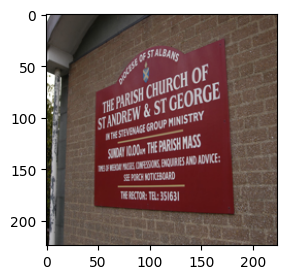

Lots of folks come out and set up tables to sell their crafts.


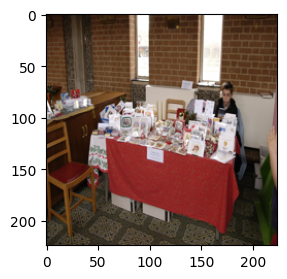

Some of these crafts are very unique and take a lot of talent to make.


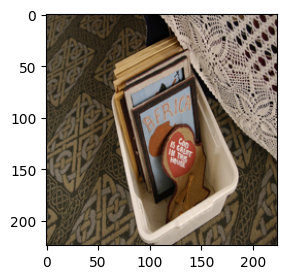

Folks of all ages come out to peruse the crafts for sale.


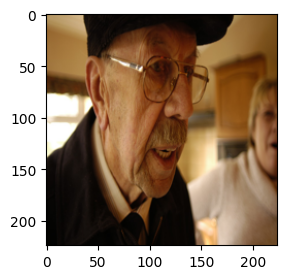

Some of the crafters even dress up in unique costumes as part of their selling act. [RET]


In [14]:
story_id = '45530'
num_captions = 5
include_images = True
as_prompt = True

story_list = create_story_list(stories_df, story_id, num_captions, include_images, as_prompt)

display_interleaved_outputs(story_list)